# Chapter 8

## Question 10

Using boosting to predict `Salary` in the `Hitters` data set

In [80]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection
import sklearn.ensemble
import sklearn.tree
import sklearn.metrics
import sklearn.neighbors

from collections import namedtuple
from tqdm import tqdm_notebook

sns.set(style="whitegrid")

In [3]:
hitters = sm.datasets.get_rdataset("Hitters", "ISLR").data

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [38]:
print(hitters.dtypes)

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
LogSalary    float64
dtype: object


In [40]:
for column in ["League", "Division", "NewLeague"]:
    print(hitters[column].value_counts())
    print()

A    139
N    124
Name: League, dtype: int64

W    134
E    129
Name: Division, dtype: int64

A    141
N    122
Name: NewLeague, dtype: int64



### (a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries

In [20]:
hitters = hitters.dropna(subset=["Salary"])
hitters["LogSalary"] = np.log(hitters["Salary"])

### (b) Creating a training set consisting of the first 200 observations, and a test set consisting of the remaining observations

In [43]:
# I'm not doing this, I'll use test_train_split instead
X = hitters.drop(columns=["Salary", "LogSalary"])
y = hitters.LogSalary

# Encode categoricals
for col in  ["League", "Division", "NewLeague"]:
    X = pd.concat([X, pd.get_dummies(X[col], prefix=col, drop_first=True)],axis=1).drop(columns=col)


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=len(hitters)-200)

### (c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter $\lambda$. Produce a plot of shrinkage against training MSE.

In [66]:
DataPoint = namedtuple('DataPoint', 'shrinkage_lambda, train_mse, test_mse')

data = []

for shrinkage_lambda in tqdm_notebook(np.linspace(0.001, 3, 100)):
    boost_regressor = sklearn.ensemble.AdaBoostRegressor(base_estimator=sklearn.tree.DecisionTreeRegressor(max_depth=3),
                                                        n_estimators=1000,
                                                         learning_rate=shrinkage_lambda
                                                        )
    boost_regressor.fit(X_train, y_train)
    y_pred_train = boost_regressor.predict(X_train)
    training_mse = sklearn.metrics.mean_squared_error(y_train, y_pred_train)
    y_pred_test = boost_regressor.predict(X_test)
    test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred_test)

    data.append(DataPoint(shrinkage_lambda, training_mse, test_mse))


### (d) Produce a plot of shrinkage vs test set MSE 

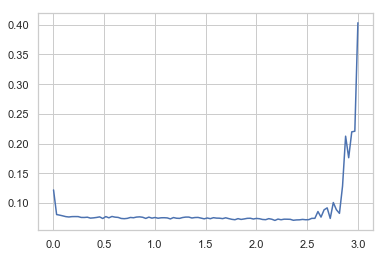

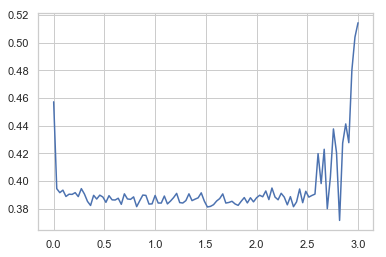

In [67]:
lambdas = [x.shrinkage_lambda for x in data]
train_mses = [x.train_mse for x in data]
test_mses = [x.test_mse for x in data]
plt.plot(lambdas, train_mses)
plt.show()
plt.plot(lambdas, test_mses)
plt.show()

### (e) Compare the test MSE of boosting to the test set MSE resulting from two of the regression approaches in Chapters 3 and 6

In [75]:
parameters = {'base_estimator__max_depth': range(1,4),
              'n_estimators': [100,1000,10000],
              'learning_rate': np.linspace(0.001,1,100)
             }
tree = sklearn.tree.DecisionTreeRegressor()
boosted_regressor = sklearn.ensemble.AdaBoostRegressor(base_estimator=tree)
clf = sklearn.model_selection.GridSearchCV(boosted_regressor, parameters, n_jobs=4, cv=5)
clf.fit(X=X_train, y=y_train)
best_tree = clf.best_estimator_

print (clf.best_score_, clf.best_params_) 




0.727509148005363 {'base_estimator__max_depth': 3, 'learning_rate': 0.989909090909091, 'n_estimators': 100}


In [85]:
# Chapter 3: Linear Regression and KNN
boosted_tree_test_mse = sklearn.metrics.mean_squared_error(y_test, best_tree.predict(X_test))

linear_regression = sklearn.linear_model.LinearRegression()
linear_regression.fit(X_train,y_train)

y_pred = linear_regression.predict(X_test)
linear_regression_test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)

knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train) # reshape required to cast the training data to a 2d array
y_pred = knn_model.predict(X_test)
knn_test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)

# Chapter 6: Ridge Regression/Lasso
# Use the LassoCV

lasso_model = sklearn.linear_model.LassoLarsCV(cv=5, max_iter=1e6)
lasso_model.fit(X_train,y_train)  # Don't really need to separate the data as we are using CV
y_pred = lasso_model.predict(X_test)
lasso_test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)

ridge_regression = sklearn.linear_model.RidgeCV(cv=5)
ridge_regression.fit(X_train,y_train)  # Don't really need to separate the data as we are using CV
y_pred = ridge_regression.predict(X_test)
ridge_test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)


print(f"Boosting: {boosted_tree_test_mse:.2f}")
print(f"Linear Regression: {linear_regression_test_mse:.2f}")
print(f"KNN: {knn_test_mse:.2f}")
print(f"Lasso: {lasso_test_mse:.2f}")
print(f"Ridge Regression: {ridge_test_mse:.2f}")


Boosting: 0.40
Linear Regression: 0.69
KNN: 0.49
Lasso: 0.61
Ridge Regression: 0.69


### (f) Which variables appear to be the most important predictors in the boosted model?


Feature ranking:
1. CAtBat: 0.18
2. CRuns: 0.13
3. CWalks: 0.10
4. CHits: 0.09
5. CRBI: 0.08
6. Walks: 0.07
7. PutOuts: 0.06
8. HmRun: 0.05
9. Runs: 0.05
10. Hits: 0.03
11. AtBat: 0.03
12. RBI: 0.03
13. Years: 0.03
14. Division_W: 0.02
15. CHmRun: 0.02
16. Assists: 0.02
17. Errors: 0.01
18. NewLeague_N: 0.00
19. League_N: 0.00


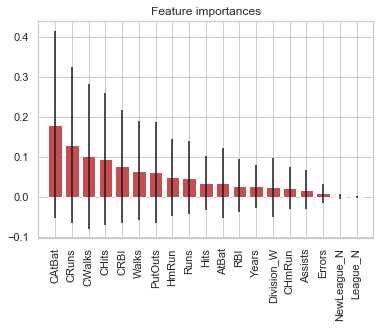

In [87]:
def getFeatureImportance(random_forest, X):
    """Given a trained classifier, plot the feature importance"""
    importances = random_forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    text_indices = [X.columns[i] for i in indices]
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print(f"{f+1}. {text_indices[f]}: {importances[indices[f]] :.2f}")

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), text_indices, rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

getFeatureImportance(best_tree, X)


### (g) Now apply bagging to the training set. What is the test set MSE for this approach?

In [88]:
# A random forest, when all predictors are consider, is equivalent to using bagging
parameters = {'max_depth': range(1,10),
              'n_estimators': [100,1000,10000],
              'max_leaf_nodes': [5,10,50,100,500]
             }
random_forest = sklearn.ensemble.RandomForestRegressor(max_features=None)
random_forest_cv = sklearn.model_selection.GridSearchCV(random_forest, parameters, n_jobs=4, cv=5)
random_forest_cv.fit(X=X_train, y=y_train)
best_random_forest = random_forest_cv.best_estimator_

print (random_forest_cv.best_score_, random_forest_cv.best_params_) 

y_pred = random_forest_cv.predict(X_test)
bagging_test_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print(f"Bagging: {bagging_test_mse:.2f}")

/home/will/.local/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/will/.local/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/will/.local/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/will/.local/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A wor

0.7160322979839292 {'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100}
Bagging: 0.44
